# Project 2: Introduction to Financial Engineering

You want to invest DKK 100.000 in a portfolio of mutual funds and ETFs using the Markowitz model.

## Asset Universe

Having learnt about the Investment Funnel tool in this course, you decide to pick your portfolios from the following asset universe:

<div>
<img src="Project%202%20-%20IFE2021_Assets.jpg" width="400"/>
</div>

You may assume that the risk free rate of return is 0.00 (0%). Download weekly adjusted
returns from the Investment Funnel from January 11, 2012 until August 18, 2021 for the 17
given assets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import cvxpy as cp

from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from numpy.linalg import inv

In [2]:
# get weekly data from algostrata dataset by ISIN
AssetUniverse_isin = pd.read_parquet('algostrata_isin.parquet')
# get ISIN of assets
tickers = AssetUniverse_isin.columns.values

# get weekly data from algostrata dataset by Name
AssetUniverse_name = pd.read_parquet('algostrata_name.parquet')
# get names of assets
names = AssetUniverse_name.columns.values

In [3]:
# get selected assets from csv file
selected_assets_info = pd.read_csv('Selected_assets.csv', sep=';')
selected_assets_name = selected_assets_info['Name'].to_list()

# get weekly returns data just for the selected assets by the Investment Funnel
SelectedAssets_returns = AssetUniverse_name[selected_assets_name]
SelectedAssets_returns.head()

BI Private Equity  \
2012-01-11 00:00:00+00:00          -0.000341   
2012-01-18 00:00:00+00:00           0.027318   
2012-01-25 00:00:00+00:00           0.062323   
2012-02-01 00:00:00+00:00          -0.020807   
2012-02-08 00:00:00+00:00           0.038824   

                           Danske Invest Bioteknologi Indeks KL  \
2012-01-11 00:00:00+00:00                              0.119967   
2012-01-18 00:00:00+00:00                              0.023630   
2012-01-25 00:00:00+00:00                              0.030809   
2012-02-01 00:00:00+00:00                              0.011589   
2012-02-08 00:00:00+00:00                              0.034456   

                           Danske Obligationer Absolut - Lav Risiko  \
2012-01-11 00:00:00+00:00                                  0.000000   
2012-01-18 00:00:00+00:00                                  0.000000   
2012-01-25 00:00:00+00:00                                  0.000000   
2012-02-01 00:00:00+00:00                                  0.001872   
2012-02-08 00:00:00+00:00                                  0.000000   

                           Fundamental Invest Stock Pick  \
2012-01-11 00:00:00+00:00                       0.032436   
2012-01-18 00:00:00+00:00                       0.048908   
2012-01-25 00:00:00+00:00                      -0.010940   
2012-02-01 00:00:00+00:00                       0.027277   
2012-02-08 00:00:00+00:00                       0.014844   

                           Jyske Invest Emerging Markets Bond CL  \
2012-01-11 00:00:00+00:00                               0.013744   
2012-01-18 00:00:00+00:00                              -0.009472   
2012-01-25 00:00:00+00:00                              -0.000730   
2012-02-01 00:00:00+00:00                              -0.008455   
2012-02-08 00:00:00+00:00                               0.004844   

                           Jyske Invest Indiske Aktier KL  \
2012-01-11 00:00:00+00:00                        0.068514   
2012-01-18 00:00:00+00:00                        0.031990   
2012-01-25 00:00:00+00:00                        0.030998   
2012-02-01 00:00:00+00:00                        0.026424   
2012-02-08 00:00:00+00:00                        0.018517   

                           Jyske Invest High Yield Corp Bond CL  \
2012-01-11 00:00:00+00:00                              0.005917   
2012-01-18 00:00:00+00:00                              0.009519   
2012-01-25 00:00:00+00:00                              0.011319   
2012-02-01 00:00:00+00:00                              0.015219   
2012-02-08 00:00:00+00:00                              0.011017   

                           Maj Invest Kontra  ValueInvest Japan A  \
2012-01-11 00:00:00+00:00           0.008606            -0.000308   
2012-01-18 00:00:00+00:00          -0.010395            -0.007467   
2012-01-25 00:00:00+00:00          -0.010565            -0.027729   
2012-02-01 00:00:00+00:00           0.003498             0.020847   
2012-02-08 00:00:00+00:00          -0.006727            -0.019669   

                           Investin HP Wealth Korte Danske Oblig KL  \
2012-01-11 00:00:00+00:00                                  0.000000   
2012-01-18 00:00:00+00:00                                  0.000000   
2012-01-25 00:00:00+00:00                                  0.000000   
2012-02-01 00:00:00+00:00                                  0.002111   
2012-02-08 00:00:00+00:00                                  0.000000   

                           iShares Global Clean Energy ETF USD Dist  \
2012-01-11 00:00:00+00:00                                  0.066046   
2012-01-18 00:00:00+00:00                                  0.013430   
2012-01-25 00:00:00+00:00                                 -0.030453   
2012-02-01 00:00:00+00:00                                  0.008784   
2012-02-08 00:00:00+00:00                                  0.048572   

                           iShares STOXX Europe 600 Telecom (DE)  \
2012-01-11 00:00:00+00:00      

In [4]:
# Function computing the geometric mean of annual returns
def meanRetAn(data):             
    Result = 1
    for i in range(len(data.index)):
        Result *= (1+data.iloc[i,:])
    
    Result = Result**(1/float(len(data.index)/52))-1
    
    return(Result)

# annualize expected return of selected assets
Assets_annualmean = meanRetAn(SelectedAssets_returns)

# covariance matrix of selected assets
Assets_VarCov = SelectedAssets_returns.cov()
# covariance matrix of selected assets (annualized)
Assets_VarCov_ann = SelectedAssets_returns.cov() * 52

# correlation matrix of selected assets
Assets_corr = SelectedAssets_returns.corr()

assets = SelectedAssets_returns.columns

print("The annual expected return are:\n", Assets_annualmean)
# print("\nThe annual covariance matrix:\n")
# SelectedAssets_cov

The annual expected return are:
 BI Private Equity                          -0.132457
Danske Invest Bioteknologi Indeks KL        0.190000
Danske Obligationer Absolut - Lav Risiko    0.009664
Fundamental Invest Stock Pick               0.236036
Jyske Invest Emerging Markets Bond CL       0.057225
Jyske Invest Indiske Aktier KL              0.112985
Jyske Invest High Yield Corp Bond CL        0.060313
Maj Invest Kontra                          -0.010708
ValueInvest Japan A                         0.084585
Investin HP Wealth Korte Danske Oblig KL    0.013440
iShares Global Clean Energy ETF USD Dist    0.138924
iShares STOXX Europe 600 Telecom (DE)       0.039537
iShares STOXX Europe 600 Food&Bev (DE)      0.098014
iShares MSCI Mexico Capped ETF USD Acc      0.016177
iShares STOXX Europe 600 Trav & Leis(DE)    0.105453
iShares MSCI Korea ETF USD Dist             0.080886
iShares EM Infrastructure ETF USD Dist      0.029889
Name: 2012-01-11 00:00:00+00:00, dtype: float64


## Question 1

<font color=blue> 1.1- Explain how these 17 assets were chosen in the Investment Funnel to the TA when you present your results. In other words explain how the Minimum Spanning Tree method is used to choose these assets. (Hint: Kourosh has given a lecture on this topic Wednesday 13th of October). </font><BR>

With hundreds of ETFs and mutual funds, it can be difficult to choose which to invest in and which not to invest in - even with an model-based algorithm. Here it can be useful to reduce the amount of assets in the universe and thus construct a subset of fewer assets but with a high diversification. This reduces parameter uncertainty and improves the out-of-sample performance of the model.

This can be done by using the Minimum Spanning Tree (MST) method. An MST is a subset of the univese and the goal of the method is to have this minimized universe of assets, while keeping the high diversity based on the correlation between the assets.

## Question 2

<font color=blue> 2.1- Assuming your 100.000 DKK in any of these 17 assets at the beginning of the period, draw 17 graphs in the same frame showing the development of your investment during the entire period. </font><BR>

We construct an empty dataframe called 'portfolios'. In this dataframe we store the investment value, when investing 100.000DKK in each of the 17 assets.

In [5]:
port = pd.DataFrame(columns=["portValue"],index = SelectedAssets_returns.index)
portfolios = pd.DataFrame( index = SelectedAssets_returns.index)
for i in SelectedAssets_returns:
    budget = 100000
    for p in SelectedAssets_returns.index:
        budget += budget * SelectedAssets_returns[i][p]
        
        port.loc[p] = budget
    portfolios.insert(SelectedAssets_returns.columns.get_loc(i), i, port)

    
portfolios

BI Private Equity  \
2012-01-11 00:00:00+00:00           99965.9   
2012-01-18 00:00:00+00:00            102697   
2012-01-25 00:00:00+00:00            109097   
2012-02-01 00:00:00+00:00            106827   
2012-02-08 00:00:00+00:00            110975   
...                                     ...   
2021-07-28 00:00:00+00:00           25380.2   
2021-08-04 00:00:00+00:00           25380.2   
2021-08-11 00:00:00+00:00           25380.2   
2021-08-18 00:00:00+00:00           25297.8   
2021-08-25 00:00:00+00:00           25297.8   

                          Danske Invest Bioteknologi Indeks KL  \
2012-01-11 00:00:00+00:00                               111997   
2012-01-18 00:00:00+00:00                               114643   
2012-01-25 00:00:00+00:00                               118175   
2012-02-01 00:00:00+00:00                               119545   
2012-02-08 00:00:00+00:00                               123664   
...                                                        ...   
2021-07-28 00:00:00+00:00                               521694   
2021-08-04 00:00:00+00:00                               539560   
2021-08-11 00:00:00+00:00                               535116   
2021-08-18 00:00:00+00:00                               535540   
2021-08-25 00:00:00+00:00                               537988   

                          Danske Obligationer Absolut - Lav Risiko  \
2012-01-11 00:00:00+00:00                                   100000   
2012-01-18 00:00:00+00:00                                   100000   
2012-01-25 00:00:00+00:00                                   100000   
2012-02-01 00:00:00+00:00                                   100187   
2012-02-08 00:00:00+00:00                                   100187   
...                                                            ...   
2021-07-28 00:00:00+00:00                                   109905   
2021-08-04 00:00:00+00:00                                   110049   
2021-08-11 00:00:00+00:00                                   109883   
2021-08-18 00:00:00+00:00                                   109927   
2021-08-25 00:00:00+00:00                                   109750   

                          Fundamental Invest Stock Pick  \
2012-01-11 00:00:00+00:00                        103244   
2012-01-18 00:00:00+00:00                        108293   
2012-01-25 00:00:00+00:00                        107108   
2012-02-01 00:00:00+00:00                        110030   
2012-02-08 00:00:00+00:00                        111663   
...                                                 ...   
2021-07-28 00:00:00+00:00                        732309   
2021-08-04 00:00:00+00:00                        753729   
2021-08-11 00:00:00+00:00                        758446   
2021-08-18 00:00:00+00:00                        750571   
2021-08-25 00:00:00+00:00                        776646   

                          Jyske Invest Emerging Markets Bond CL  \
2012-01-11 00:00:00+00:00                                101374   
2012-01-18 00:00:00+00:00                                100414   
2012-01-25 00:00:00+00:00                                100341   
2012-02-01 00:00:00+00:00                               99492.5   
2012-02-08 00:00:00+00:00                               99974.5   
...                                                         ...   
2021-07-28 00:00:00+00:00                                168620   
2021-08-04 00:00:00+00:00                                169454   
2021-08-11 00:00:00+00:00                                169898   
2021-08-18 00:00:00+00:00                                170557   
2021-08-25 00:00:00+00:00                                171306   

                          Jyske Invest Indiske Aktier KL  \
2012-01-11 00:00:00+00:00                         106851   
2012-01-18 00:00:00+00:00                         110270   
2012-01-25 00:00:00+00:00                         113688   
2012-02-01 00:00:00+00:00                         116692   
2012-02-08 00

We can now plot the development of the 17 investments. You can click off the assets to get a better overview of the performance of the individual investment.

In [6]:
fig = px.line(portfolios)
fig.update_layout(title = 'Weekly development of investing 100.000DKK in each asset',
                   xaxis_title = 'Date',
                   yaxis_title = 'Value of investment')
fig.show()

<font color=blue> 2.2- What are the average historical returns (in annualized terms), standard deviation of
returns (also in annualized terms) and correlation between returns? </font><BR>

We create functions to calculate the annual geometric mean, the standard deviation and the sharpe ratio.

In [7]:
# Function to calculate average weekly returns using geometric mean
def calc_mean(data):
    return (np.prod(1 + data))**(1/len(data)) - 1

weeklymean = (1 + calc_mean(SelectedAssets_returns) )**52-1
weeklycov = SelectedAssets_returns.cov()
stdev_a = SelectedAssets_returns.std(axis=0) * np.sqrt(52)   #standard deviation of Annual Returns
mu_ga = (1+weeklymean)**52-1
cov_matrix_a = weeklycov*52
corr_matrix = SelectedAssets_returns.corr()

#Function for getting statistics based on the weekly returns.
def getStat(data):
    # TABLE WITH AVG RET AND STD OF RET
    mu_ga = (1 + calc_mean(data) )**52-1                  #anual geometric mean
    stdev_a = data.std(axis=0) * np.sqrt(52)   #standard deviation of Annual Returns
    #stdev_a = annualReturns.std(axis=0)        

    statDf = pd.concat([mu_ga,stdev_a], axis=1)         #table
    statName = ["Average Annual Returns","Standard Deviation of Returns"]
    statDf.columns = statName                           #add names
    
    # COMPUTE SHARPE RATIO AND ADD IT INTO THE TABLE
    sharpe = statDf.loc[:,"Average Annual Returns"]/statDf.loc[:,"Standard Deviation of Returns"]
    statDf = pd.concat([statDf,sharpe], axis=1)         #add sharpe ratio into the table
    statName = ["Average Annual Returns","Standard Deviation of Returns", "Sharpe Ratio"]
    statDf.columns = statName
    
    # ADD NAMES INTO THE TABLE
    statDf["Name"] = data.columns 
    
    return(statDf) 

And we get an overview the statistics:

In [8]:
return_statistics = getStat(SelectedAssets_returns)
return_statistics.head()

Average Annual Returns  \
BI Private Equity                                      -0.132457   
Danske Invest Bioteknologi Indeks KL                    0.190000   
Danske Obligationer Absolut - Lav Risiko                0.009664   
Fundamental Invest Stock Pick                           0.236036   
Jyske Invest Emerging Markets Bond CL                   0.057225   

                                          Standard Deviation of Returns  \
BI Private Equity                                              0.229283   
Danske Invest Bioteknologi Indeks KL                           0.258206   
Danske Obligationer Absolut - Lav Risiko                       0.008094   
Fundamental Invest Stock Pick                                  0.184489   
Jyske Invest Emerging Markets Bond CL                          0.096884   

                                          Sharpe Ratio  \
BI Private Equity                            -0.577702   
Danske Invest Bioteknologi Indeks KL          0.735848   
Danske Obligationer Absolut - Lav Risiko      1.194048   
Fundamental Invest Stock Pick                 1.279406   
Jyske Invest Emerging Markets Bond CL         0.590656   

                                                                              Name  
BI Private Equity                                                BI Private Equity  
Danske Invest Bioteknologi Indeks KL          Danske Invest Bioteknologi Indeks KL  
Danske Obligationer Absolut - Lav Risiko  Danske Obligationer Absolut - Lav Risiko  
Fundamental Invest Stock Pick                        Fundamental Invest Stock Pick  
Jyske Invest Emerging Markets Bond CL        Jyske Invest Emerging Markets Bond CL

Thus we can plot the annual mean, annual standard deviation for each asset. By holding the mouse over each asset, we can also see the sharpe ratio.

In [9]:
fig = px.scatter(return_statistics, 
                 x="Standard Deviation of Returns",
                 y="Average Annual Returns", 
                 hover_data=["Sharpe Ratio", "Name"],
                 color= "Name",
                 title="The Relationship between Annual Returns and Standard Deviation of Returns")
fig.layout.yaxis.tickformat = ',.1%'
fig.layout.xaxis.tickformat = ',.1%'
fig.show()

We can illustrate the correlations in the following

<AxesSubplot:>

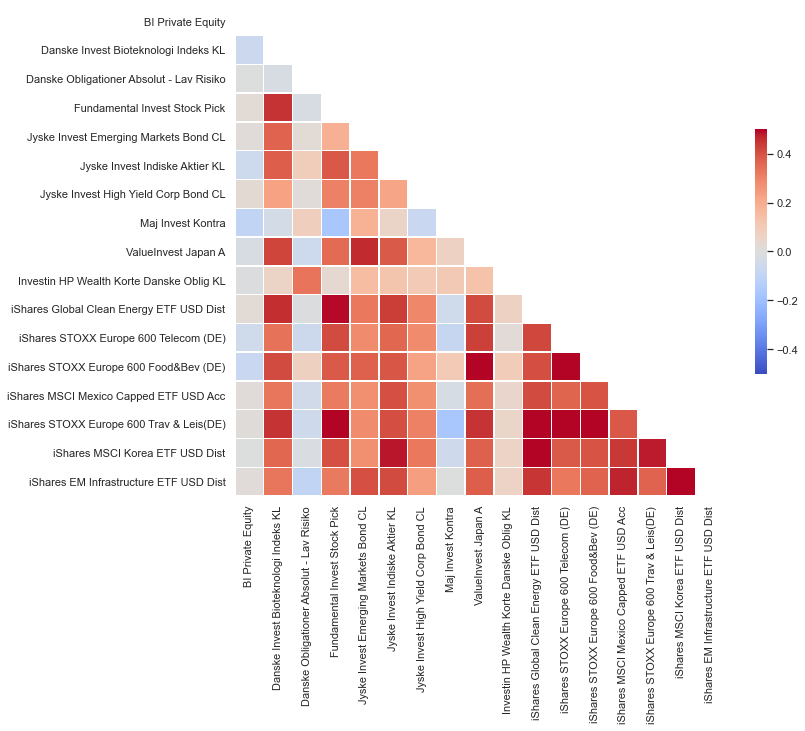

In [10]:
# autocorrelation function
def corr_crytoReturns(WeeklyReturns):
    return WeeklyReturns.corr(method='spearman')
#     return WeeklyReturns.corr(method='pearson')

# call autocorrelation function
WeeklyReturns_corr = corr_crytoReturns(SelectedAssets_returns)

# set theme
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(WeeklyReturns_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = 'coolwarm'

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(WeeklyReturns_corr, mask=mask, cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<font color=blue> 2.3- What does the distribution of returns look like? What are the range, skewness, kurtosis and autocorrelation of the returns? What is the Sharpe Ratio of each asset? </font><BR>

We plot a histogram to see the distribution of returns for each asset. Unpress all the variables and then press a variable individually to see the distribution and range of the returns

In [11]:
fig = px.histogram(SelectedAssets_returns)
fig

We can find the skewness by using the skew function in python

Skewness is a measure of the asymmetry of a distribution. 
This value can be positive or negative.

A negative skew indicates that the tail is on the left side of the distribution, 
which extends towards more negative values.

A positive skew indicates that the tail is on the right side of the distribution, 
which extends towards more positive values.

A value of zero indicates that there is no skewness in the distribution at all, 
meaning the distribution is perfectly symmetrical.

In [12]:
skewness = skew(SelectedAssets_returns, bias=False)
skewness = pd.DataFrame(skewness, index = assets)
skewness

0
BI Private Equity                        -8.047886
Danske Invest Bioteknologi Indeks KL     -0.222429
Danske Obligationer Absolut - Lav Risiko -1.445026
Fundamental Invest Stock Pick            -1.125802
Jyske Invest Emerging Markets Bond CL    -1.208434
Jyske Invest Indiske Aktier KL           -0.598205
Jyske Invest High Yield Corp Bond CL     -3.571915
Maj Invest Kontra                         0.270819
ValueInvest Japan A                      -0.271927
Investin HP Wealth Korte Danske Oblig KL -3.587066
iShares Global Clean Energy ETF USD Dist -0.417808
iShares STOXX Europe 600 Telecom (DE)    -0.161517
iShares STOXX Europe 600 Food&Bev (DE)   -0.224429
iShares MSCI Mexico Capped ETF USD Acc   -0.772752
iShares STOXX Europe 600 Trav & Leis(DE) -1.293102
iShares MSCI Korea ETF USD Dist          -0.443807
iShares EM Infrastructure ETF USD Dist    3.585400


We can now find the Kurtosis by using the following function in python



In [13]:
kurt = kurtosis(SelectedAssets_returns, bias=False)
kurt = pd.DataFrame(kurt, index = assets)
kurt

0
BI Private Equity                         109.120606
Danske Invest Bioteknologi Indeks KL        1.373337
Danske Obligationer Absolut - Lav Risiko   19.120827
Fundamental Invest Stock Pick               6.255802
Jyske Invest Emerging Markets Bond CL       7.572606
Jyske Invest Indiske Aktier KL              2.945802
Jyske Invest High Yield Corp Bond CL       59.431882
Maj Invest Kontra                           1.427189
ValueInvest Japan A                         1.547546
Investin HP Wealth Korte Danske Oblig KL   47.811330
iShares Global Clean Energy ETF USD Dist    3.993486
iShares STOXX Europe 600 Telecom (DE)       8.436925
iShares STOXX Europe 600 Food&Bev (DE)      6.177210
iShares MSCI Mexico Capped ETF USD Acc      4.813890
iShares STOXX Europe 600 Trav & Leis(DE)   19.880899
iShares MSCI Korea ETF USD Dist             2.853641
iShares EM Infrastructure ETF USD Dist     54.672236

Kurtosis is a measure of whether or not a distribution is 
heavy-tailed or light-tailed relative to a normal distribution.

The kurtosis of a normal distribution is 3.

If a given distribution has a kurtosis less than 3, 
it is said to be playkurtic, which means it tends to produce 
fewer and less extreme outliers than the normal distribution.

If a given distribution has a kurtosis greater than 3, 
it is said to be leptokurtic, which means it tends to produce 
more outliers than the normal distribution.

We will now find the autocorrelations for each asset. It is not specified in the assignemt how many lags we should do this for, but we can use the inbuilt function in python and find the autocorrelations.

Autocorrelation measures the relationship between a variable's current value and its past values.
An autocorrelation of +1 represents a perfect positive correlation (an increase seen in one time series leads to a proportionate increase in the other time series). On the other hand, an autocorrelation of -1 represents a perfect negative correlation (an increase seen in one time series results in a proportionate decrease in the other time series).



In [14]:
#DATA FRAME TO STORE ACCOUNT VALUE FOR ALL LEVERAGE FACTORS
autocorrelations = pd.DataFrame()
for i in assets:
    autocorrelation = acf(SelectedAssets_returns[i], nlags = 20, fft = True)
    autocorrelations.insert(portfolios.columns.get_loc(i), i, autocorrelation)
autocorrelations


BI Private Equity  Danske Invest Bioteknologi Indeks KL  \
0            1.000000                              1.000000   
1           -0.020362                              0.030064   
2            0.015490                             -0.029221   
3           -0.001374                             -0.060517   
4            0.002810                             -0.125781   
5           -0.006587                              0.017596   
6           -0.007968                             -0.057107   
7           -0.044217                              0.042368   
8            0.002613                              0.046565   
9           -0.010500                              0.002584   
10          -0.004009                              0.006986   
11          -0.008071                             -0.110752   
12          -0.006985                             -0.044476   
13           0.021890                             -0.026295   
14          -0.040303                             -0.063106   
15          -0.028071                              0.045761   
16           0.011235                              0.053526   
17          -0.021470                              0.003501   
18           0.020991                              0.044895   
19          -0.023657                             -0.029651   
20           0.004865                              0.019127   

    Danske Obligationer Absolut - Lav Risiko  Fundamental Invest Stock Pick  \
0                                   1.000000                       1.000000   
1                                  -0.017652                       0.077548   
2                                  -0.057587                      -0.049594   
3                                   0.002406                      -0.006881   
4                                   0.044119                      -0.005220   
5                                   0.002783                       0.009008   
6                                  -0.026664                      -0.028965   
7                                  -0.050040                      -0.005904   
8                                   0.049482                      -0.011503   
9                                   0.181084                      -0.002756   
10                                 -0.055184                       0.032033   
11                                 -0.064480                      -0.028889   
12                                  0.032863                       0.027588   
13                                  0.042120                      -0.022071   
14                                  0.037571                      -0.001035   
15                                  0.026072                      -0.034376   
16                                 -0.041951                      -0.008516   
17                                  0.049472                       0.036723   
18                                  0.057267                      -0.008765   
19                                 -0.041299                       0.061189   
20                                 -0.023384                       0.051387   

    Jyske Invest Emerging Markets Bond CL  Jyske Invest Indiske Aktier KL  \
0                                1.000000                        1.000000   
1                                0.032506                        0.060911   
2                                0.008603                       -0.034536   
3                               -0.050809                        0.002748   
4                               -0.076231                        0.014209   
5                               -0.034574                       -0.052797   
6                                0.062509                       -0.079528   
7                               -0.041853                       -0.044297   
8                               -0.012001                       -0.005355   
9                                0.023284                       -0.049908   
10                             

We can then plot the autocorrelation functions from where we get

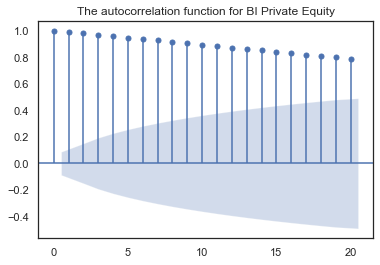

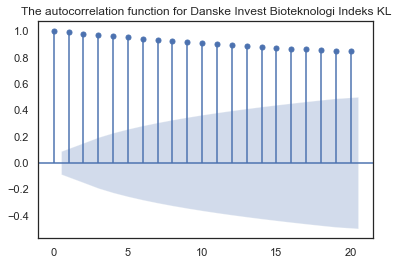

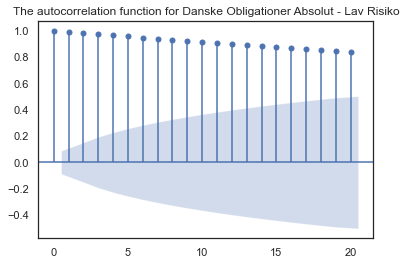

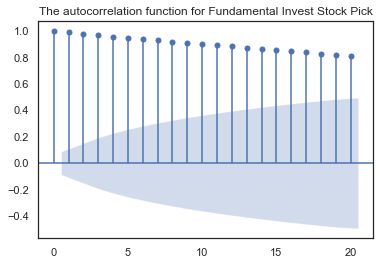

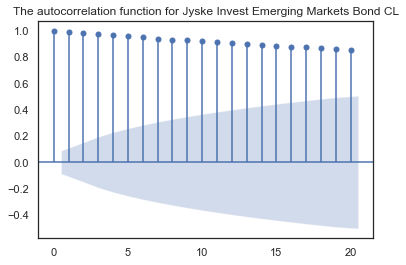

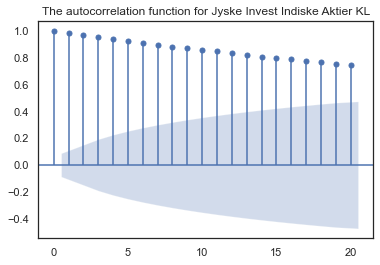

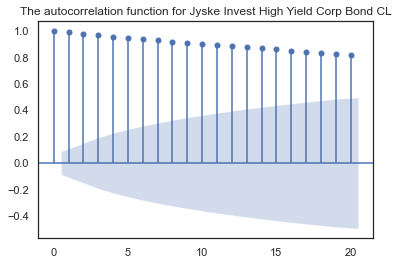

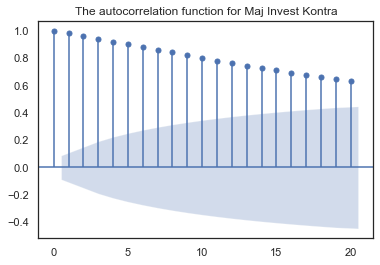

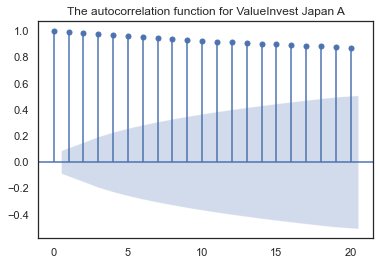

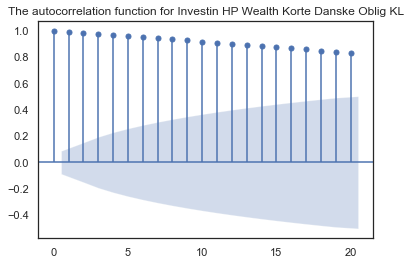

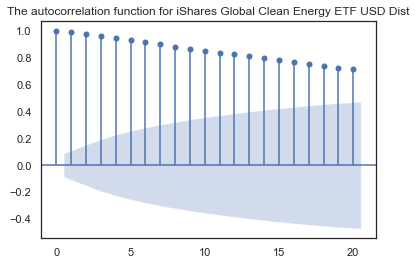

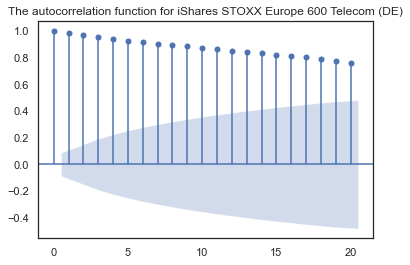

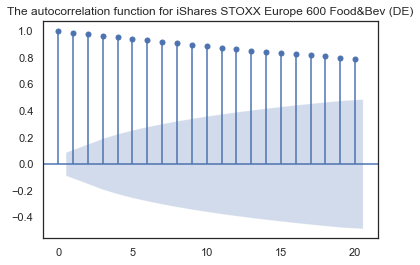

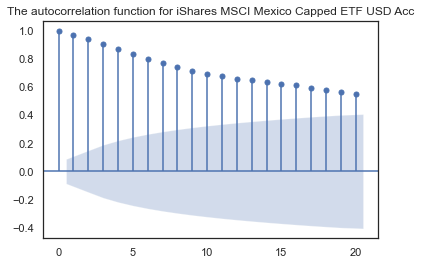

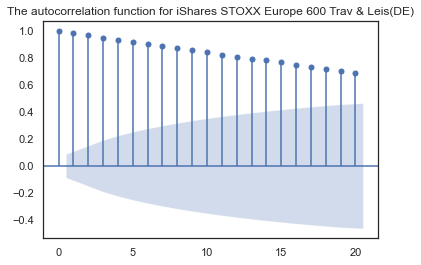

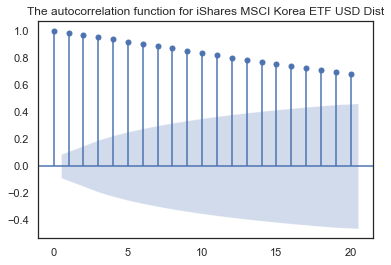

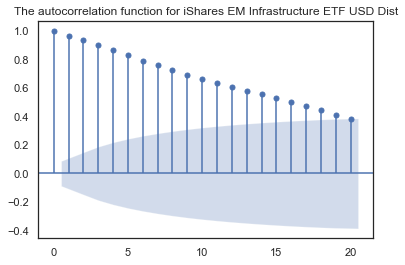

In [15]:
for i in selected_assets_name:
    plot_acf(portfolios[i].values.squeeze(), lags = 20, title = 'The autocorrelation function for ' + i)

The blue shaded region is the confidence interval with a default value of α = 0.05. Anything within this range represents a value that has no significant correlation with the most recent value for the price.

The vertical lines with markers at their tops are the “lags” that represent a specific number (50, in this case) of previous values. These represent the correlation value (shown on the y-axis) and diminish at a steady rate as their proximity from the current price increases.

## Question 3

Based on the Markowitz portfolio theory, derive and illustrate the optimal portfolio choices. Identify the following portfolios in terms of weights, return and risk:

In [16]:
annual_mean = np.asarray(return_statistics['Average Annual Returns'])
annual_cov = Assets_VarCov_ann.values

# define risk free asset
Rf = 0.0

<font color=blue> 3.1- The maximum expected return portfolio. </font><BR>

In [17]:
# Markowitz Mean-Variance model for maximum expected return portfolio
def MaxReturnPort(mu,VarCov,returns):
    
     # define index
    i_idx = returns.columns
    j_idx = returns.index
    
    # number of returns
    N = returns.shape[0] 
    
    # DATA FRAME TO STORE PORTFOLIO ALLOCATION FOR ALL DATASET
    portAllocation = pd.DataFrame(columns=i_idx, index=['Portfolio weights'])
    
    #####################################
    ## define model
    #####################################
    
    # reshape annualize expected returns array
    mu = np.asarray(mu).reshape(-1,1)
    
    # define variables
    x = cp.Variable(shape=(len(i_idx),), name="x")
    mu_p = cp.Variable(name="mu_p")
    var_p = cp.quad_form(x,VarCov)
    
    ## Objective Function: Markowitz model 
    model = cp.Problem(cp.Maximize(mu.T @ x),
                      [cp.sum(x) == 1,                         # weight constraint
                       x.T @ mu == mu_p,                       # portfolio expected return
                       x >= 0])                                # no shot-selling allowed
    
    # solve the Markowitz model for each lambda value 
    model.solve(solver = cp.ECOS, verbose=True)
        
    # print an error if the model is not optimal
    if model.status != 'optimal':
        print("Whoops! There is an error! The model has error status:" + model.status )
        
    # save values if model is optimal
    if model.status == 'optimal':
            
        Markowitz_model = dict()
            
        print("Optimal portfolio")
        print("----------------------")
#         print("Optimal value: %s" % model.value)
        for variable in model.variables():
#             print("Variable %s: value %s" % (variable.name(), variable.value))
            Markowitz_model[variable.name] = variable.value
                
        # solution with variable names   
        Markowitz_model = pd.Series(Markowitz_model,index=Markowitz_model.keys())           
            
        print("----------------------")
        print("Portfolio allocation:") 
        print("----------------------")
        for s in range(len(i_idx)):
            x.value[s] = round(x.value[s],4)
            print(" Investment in {} : {}% of the portfolio".format(i_idx[s],round(x.value[s],2)*100))
        print("----------------------")
        
        print()
        print("Expected portfolio return = {}%".format(round(float(mu_p.value*100), 4)))
        print("Expected portfolio variance (%)   = {}%".format(round(var_p.value*100,4)))
        print("Expected portfolio standard deviation (%)   = {}%".format(round(np.sqrt(var_p.value)*100,4)))

        port_total = pd.Series(x.value ,index=i_idx)
            
        opt_port = port_total
            
    # set flooting data points to zero and normalize
    opt_port[opt_port < 0.00001] = 0
    portAllocation.iloc[0,:] = opt_port/sum(opt_port)
    port_return = mu_p.value
    port_var = var_p.value
    port_std = np.sqrt(var_p.value)
    
    return portAllocation, port_return, port_var, port_std

In [18]:
MaxRet_alloc, MaxRet_return, MaxRet_var, MaxRet_std = MaxReturnPort(annual_mean, 
                                                                    annual_cov, 
                                                                    SelectedAssets_returns)
MaxRet_alloc

                                     CVXPY                                     
                                    v1.1.12                                    
(CVXPY) Oct 22 02:13:03 PM: Your problem has 18 variables, 3 constraints, and 0 parameters.
(CVXPY) Oct 22 02:13:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 02:13:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 22 02:13:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 22 02:13:03 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 22 02:13:03 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

BI Private Equity Danske Invest Bioteknologi Indeks KL  \
Portfolio weights                 0                                    0   

                  Danske Obligationer Absolut - Lav Risiko  \
Portfolio weights                                        0   

                  Fundamental Invest Stock Pick  \
Portfolio weights                             1   

                  Jyske Invest Emerging Markets Bond CL  \
Portfolio weights                                     0   

                  Jyske Invest Indiske Aktier KL  \
Portfolio weights                              0   

                  Jyske Invest High Yield Corp Bond CL Maj Invest Kontra  \
Portfolio weights                                    0                 0   

                  ValueInvest Japan A  \
Portfolio weights                   0   

                  Investin HP Wealth Korte Danske Oblig KL  \
Portfolio weights                                        0   

                  iShares Global Clean Energy ETF USD Dist  \
Portfolio weights                                        0   

                  iShares STOXX Europe 600 Telecom (DE)  \
Portfolio weights                                     0   

                  iShares STOXX Europe 600 Food&Bev (DE)  \
Portfolio weights                                      0   

                  iShares MSCI Mexico Capped ETF USD Acc  \
Portfolio weights                                      0   

                  iShares STOXX Europe 600 Trav & Leis(DE)  \
Portfolio weights                                        0   

                  iShares MSCI Korea ETF USD Dist  \
Portfolio weights                               0   

                  iShares EM Infrastructure ETF USD Dist  
Portfolio weights                                      0

The maximum expected return portfolio correspont to the portfolio investing 100% of the capital in the asset with highest expected return, which in this case is the Fundamental Invest Stock Pick fund.

<font color=blue> 3.2- The global minimum variance portfolio. </font><BR>

In [19]:
# Markowitz Mean-Variance model for minimum global variance portfolio
def MinVarPort(mu,VarCov,returns):
    
     # define index
    i_idx = returns.columns
    j_idx = returns.index
    
    # number of returns
    N = returns.shape[0] 
    
    # DATA FRAME TO STORE PORTFOLIO ALLOCATION FOR ALL DATASET
    portAllocation = pd.DataFrame(columns=i_idx, index=['Portfolio weights'])
    
    #####################################
    ## define model
    #####################################
    
    # reshape annualize expected returns array
    mu = np.asarray(mu).reshape(-1,1)
    
    # define variables
    x = cp.Variable(shape=(len(i_idx),), name="x")
    mu_p = cp.Variable(name="mu_p")
    var_p = cp.quad_form(x,VarCov)
    
    ## Objective Function: Markowitz model 
    model = cp.Problem(cp.Minimize(1/2*var_p),
                      [cp.sum(x) == 1,                         # weight constraint
                       x.T @ mu == mu_p,                       # portfolio expected return
                       x >= 0])                                # no shot-selling allowed
    
    # solve the Markowitz model for each lambda value 
    model.solve(solver = cp.ECOS, verbose=True)
        
    # print an error if the model is not optimal
    if model.status != 'optimal':
        print("Whoops! There is an error! The model has error status:" + model.status )
        
    # save values if model is optimal
    if model.status == 'optimal':
            
        Markowitz_model = dict()
            
        print("Optimal portfolio")
        print("----------------------")
#         print("Optimal value: %s" % model.value)
        for variable in model.variables():
#             print("Variable %s: value %s" % (variable.name(), variable.value))
            Markowitz_model[variable.name] = variable.value
                
        # solution with variable names   
        Markowitz_model = pd.Series(Markowitz_model,index=Markowitz_model.keys())           
            
        print("----------------------")
        print("Portfolio allocation:") 
        print("----------------------")
        for s in range(len(i_idx)):
            x.value[s] = round(x.value[s],4)
            print(" Investment in {} : {}% of the portfolio".format(i_idx[s],round(x.value[s],2)*100))
        print("----------------------")
        
        print()
        print("Expected portfolio return = {}%".format(round(float(mu_p.value*100), 4)))
        print("Expected portfolio variance (%)   = {}%".format(round(var_p.value*100,4)))
        print("Expected portfolio standard deviation (%)   = {}%".format(round(np.sqrt(var_p.value)*100,4)))

        port_total = pd.Series(x.value ,index=i_idx)
            
        opt_port = port_total
            
    # set flooting data points to zero and normalize
    opt_port[opt_port < 0.00001] = 0
    portAllocation.iloc[0,:] = opt_port/sum(opt_port)
    port_return = mu_p.value
    port_var = var_p.value
    port_std = np.sqrt(var_p.value)
    
    return portAllocation, port_return, port_var, port_std

In [20]:
GMV_alloc, GMV_return, GMV_var, GMV_std = MinVarPort(annual_mean, 
                                                     annual_cov, 
                                                     SelectedAssets_returns)
GMV_alloc

                                     CVXPY                                     
                                    v1.1.12                                    
(CVXPY) Oct 22 02:13:03 PM: Your problem has 18 variables, 3 constraints, and 0 parameters.
(CVXPY) Oct 22 02:13:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 22 02:13:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 22 02:13:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 22 02:13:03 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 22 02:13:03 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

BI Private Equity Danske Invest Bioteknologi Indeks KL  \
Portfolio weights            0.0001                                    0   

                  Danske Obligationer Absolut - Lav Risiko  \
Portfolio weights                                   0.6993   

                  Fundamental Invest Stock Pick  \
Portfolio weights                             0   

                  Jyske Invest Emerging Markets Bond CL  \
Portfolio weights                                     0   

                  Jyske Invest Indiske Aktier KL  \
Portfolio weights                              0   

                  Jyske Invest High Yield Corp Bond CL Maj Invest Kontra  \
Portfolio weights                                    0            0.0138   

                  ValueInvest Japan A  \
Portfolio weights              0.0012   

                  Investin HP Wealth Korte Danske Oblig KL  \
Portfolio weights                                   0.2823   

                  iShares Global Clean Energy ETF USD Dist  \
Portfolio weights                                        0   

                  iShares STOXX Europe 600 Telecom (DE)  \
Portfolio weights                                0.0023   

                  iShares STOXX Europe 600 Food&Bev (DE)  \
Portfolio weights                                      0   

                  iShares MSCI Mexico Capped ETF USD Acc  \
Portfolio weights                                      0   

                  iShares STOXX Europe 600 Trav & Leis(DE)  \
Portfolio weights                                    0.001   

                  iShares MSCI Korea ETF USD Dist  \
Portfolio weights                               0   

                  iShares EM Infrastructure ETF USD Dist  
Portfolio weights                                      0

In [21]:
# selected assets in GMV portfolio
GMV_assets = GMV_alloc[GMV_alloc != 0.00].T.dropna()

# plot minimum global variance portfolio weights
fig = px.pie(GMV_assets, values='Portfolio weights', names=GMV_assets.index, 
             title='Global Minimum Variance Portfolio weights',
             color_discrete_sequence=['#EF553B', '#00CC96', '#FFA15A', '#636EFA', '#AB63FA'])
fig.show()

<font color=blue> 3.3- Draw the efficient frontier using 8 different expected returns in between the returns you found in questions 3.1 and 3.2. There should be equal distance between each pair of returns in the efficient frontier. Find the portfolio weights for each of the 8 optimal portfolios as well. </font><BR>

In [22]:
# define expected returns for 10 portfolios in the efficient frontier (equal distance)
mu_ps = np.linspace(float(GMV_return), float(MaxRet_return), num=10)
mu_ps

array([0.01069638, 0.03573408, 0.06077178, 0.08580949, 0.11084719,
       0.13588489, 0.16092259, 0.18596029, 0.21099799, 0.23603569])

In [23]:
# Markowitz Mean-Variance model for minimum global variance portfolio
def EfficientFrontier(mu,VarCov,returns, mu_ps):
    
     # define index
    i_idx = returns.columns
    j_idx = returns.index
    
    # number of returns
    N = returns.shape[0] 
    
    # DATA FRAME TO STORE PORTFOLIO ALLOCATION FOR ALL PORTFOLIOS IN THE EFFICIENT FRONTIER
    port_allocation = pd.DataFrame(columns=i_idx, index=range(len(mu_ps)))
    # DATA FRAME TO STORE PORTFOLIO EXPECTED RETURN FOR ALL PORTFOLIOS IN THE EFFICIENT FRONTIER
    port_return = pd.DataFrame(columns=['Portfolio Return'], index=range(len(mu_ps)))
    # DATA FRAME TO STORE PORTFOLIO VARIANCE FOR ALL PORTFOLIOS IN THE EFFICIENT FRONTIER
    port_var = pd.DataFrame(columns=['Portfolio Variance'], index=range(len(mu_ps)))
    # DATA FRAME TO STORE PORTFOLIO STANDARD DEVIATION FOR ALL PORTFOLIOS IN THE EFFICIENT FRONTIER
    port_std = pd.DataFrame(columns=['Portfolio Standard Deviation'], index=range(len(mu_ps)))
    
    
    #####################################
    ## define model
    #####################################
    
    # reshape annualize expected returns array
    mu = np.asarray(mu).reshape(-1,1)
    
    for i in range(len(mu_ps)):
        
        # define variables
        x = cp.Variable(shape=(len(i_idx),), name="x")
        mu_p = x.T @ mu
        var_p = cp.quad_form(x,VarCov)
    
        ## Objective Function: Markowitz model 
        model = cp.Problem(cp.Minimize(1/2*var_p - mu_p),
                          [cp.sum(x) == 1,                         # weight constraint
                           mu_p == mu_ps[i],                       # portfolio expected return equal to the target return
                           x >= 0])                                # no shot-selling allowed
        
        
        # solve the Markowitz model for each lambda value 
        model.solve(solver = cp.ECOS, verbose=False)

        # print an error if the model is not optimal
        if model.status != 'optimal':
            print("Whoops! There is an error! The model has error status:" + model.status )

        # save values if model is optimal
        if model.status == 'optimal':

            Markowitz_model = dict()

            print("Optimal portfolio", i+1)
            print("----------------------")
#             print("Optimal value: %s" % model.value)

            for variable in model.variables():
#                 print("Variable %s: value %s" % (variable.name(), variable.value))
                Markowitz_model[variable.name] = variable.value

            # solution with variable names   
            Markowitz_model = pd.Series(Markowitz_model,index=Markowitz_model.keys())           

            print("----------------------")
            print("Portfolio", i+1 , "allocation:") 
            print("----------------------")
            for s in range(len(i_idx)):
                x.value[s] = round(x.value[s],4)
                print(" Investment in {} : {}% of the portfolio".format(i_idx[s],round(x.value[s],2)*100))
            print("----------------------")

            print()
            print("Expected portfolio", i+1 , " return = {}%".format(round(float(mu_p.value*100), 4)))
            print("Expected portfolio", i+1 , " variance (%)   = {}%".format(round(var_p.value*100,4)))
            print("Expected portfolio", i+1 , " standard deviation (%)   = {}%".format(round(np.sqrt(var_p.value)*100,4)))
            print()
            
            port_total = pd.Series(x.value ,index=i_idx)

            opt_port = port_total

        # set flooting data points to zero and normalize
        opt_port[opt_port < 0.00001] = 0
    
        # save portfolio values in dataframe
        port_allocation.iloc[i,:] = opt_port/sum(opt_port)
        port_return.iloc[i,0] = float(mu_p.value)
        port_var.iloc[i,0] = float(var_p.value)
        port_std.iloc[i,0] = float(np.sqrt(var_p.value))
        
    return port_allocation, port_return, port_var, port_std

In [24]:
eff_alloc, eff_return, eff_var, eff_std = EfficientFrontier(annual_mean, 
                                                             annual_cov, 
                                                             SelectedAssets_returns,
                                                             mu_ps)

Optimal portfolio 1
----------------------
----------------------
Portfolio 1 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 0.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 70.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 0.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 0.0% of the portfolio
 Investment in Maj Invest Kontra : 1.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 28.000000000000004% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment i

In [25]:
# create dataframe with portfolio stats
eff_portfolios = pd.concat([eff_alloc, eff_return, eff_var, eff_std], axis=1)
eff_portfolios['Sharpe Ratio'] = eff_portfolios.apply(lambda row: (row['Portfolio Return'] - Rf) / row['Portfolio Standard Deviation'], axis=1)
eff_portfolios.index = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10']
eff_portfolios

BI Private Equity Danske Invest Bioteknologi Indeks KL  \
P1             0.0001                                    0   
P2                  0                               0.0082   
P3                  0                               0.0146   
P4                  0                                0.021   
P5                  0                               0.0274   
P6                  0                               0.0338   
P7                  0                               0.0402   
P8                  0                            0.0465953   
P9                  0                                0.053   
P10                 0                                    0   

    Danske Obligationer Absolut - Lav Risiko Fundamental Invest Stock Pick  \
P1                                    0.6993                             0   
P2                                         0                        0.0908   
P3                                         0                         0.195   
P4                                         0                        0.2992   
P5                                         0                        0.4034   
P6                                         0                        0.5076   
P7                                         0                        0.6119   
P8                                         0                      0.716028   
P9                                         0                        0.8203   
P10                                        0                             1   

    Jyske Invest Emerging Markets Bond CL Jyske Invest Indiske Aktier KL  \
P1                                      0                              0   
P2                                      0                              0   
P3                                      0                              0   
P4                                      0                              0   
P5                                      0                              0   
P6                                      0                              0   
P7                                      0                              0   
P8                                      0                              0   
P9                                      0                              0   
P10                                     0                              0   

    Jyske Invest High Yield Corp Bond CL Maj Invest Kontra  \
P1                                     0            0.0138   
P2                                0.0137                 0   
P3                                0.0288                 0   
P4                                 0.044                 0   
P5                                0.0591                 0   
P6                                0.0743                 0   
P7                                0.0894                 0   
P8                               0.10459                 0   
P9                                0.1197                 0   
P10                                    0                 0   

    ValueInvest Japan A Investin HP Wealth Korte Danske Oblig KL  ...  \
P1               0.0012                                   0.2823  ...   
P2                    0                                   0.8873  ...   
P3                    0                                   0.7616  ...   
P4                    0                                   0.6358  ...   
P5                    0                                   0.5101  ...   
P6                    0                                   0.3843  ...   
P7                    0                                   0.2585  ...   
P8                    0                                 0.132787  ...   
P9                    0                                    0.007  ...   
P10                   0                                        0  ...   

    iShares STOXX Europe 600 Telecom (DE)  \
P1                                 0.0023   
P2                                      0   
P3 

In [26]:
def Plot_EfficientFrontier(portfolios, EW_port, EW_opt_port, avg_ann_returns, std_ann_returns, assets, title, start, end, EW, EW_opt):

    fig = go.Figure()
    
    # Ploting Efficient Frontier
    fig.add_trace(go.Scatter(x=portfolios["Portfolio Standard Deviation"], y=portfolios["Portfolio Return"],
                             mode='lines+markers',
                             name='Efficient Frontier',
                             text=round(portfolios['Sharpe Ratio'],2)))
    

    # Plotting assets expected returns and std
    fig.add_trace(go.Scatter(x=std_ann_returns, y=avg_ann_returns,
                            mode='markers',
                            name='Assets',
                            text=assets))
    
    # include equal-weighted portfolio
    if EW == 'EW':
        # Plotting equal-weighted portfolio expected return and std
        fig.add_trace(go.Scatter(x=EW_port["Portfolio Standard Deviation"], y=EW_port["Portfolio Return"],
                                 mode='markers',
                                 name='Equal-Weighted',
                                 text='SR = '+ str(float(round(EW_port['Sharpe Ratio'],2)))))
    
    # include optimal portfolio with expected return equal to the expected return of the equal-weighted portfolio
    if EW_opt == 'EW_opt':
        # Plotting optimal portfolio with equal-weighted portfolio expected return
        fig.add_trace(go.Scatter(x=EW_opt_port["Portfolio Standard Deviation"], y=EW_opt_port["Portfolio Return"],
                                 mode='markers',
                                 name='Optimal Portfolio',
                                 text='SR = '+ str(float(round(EW_opt_port['Sharpe Ratio'],2)))))
        
    fig['layout'].update(title = title + ": Annual Returns vs. Standard Deviation of Returns from "+ start + " to " + end)
    fig.update_xaxes(title_text='Std of Returns')
    fig.update_yaxes(title_text='Average Annual Returns')
    
    # AXIS IN PERCENTAGES
    fig.layout.yaxis.tickformat = ',.1%'
    fig.layout.xaxis.tickformat = ',.1%'
    
    fig.show()

In [27]:
startDate = '11/01/2012'
endDate = '18/08/2021'

# Plot Efficient Frontier comparison for historical returns - ETFs, ETFs+5%crypto, ETFs+10%crypto 
Plot_EfficientFrontier(portfolios = eff_portfolios,
                       EW_port = None,
                       EW_opt_port = None,
                       avg_ann_returns = return_statistics['Average Annual Returns'],
                       std_ann_returns = return_statistics['Standard Deviation of Returns'],
                       assets = assets, 
                       title = 'Efficient Frontier',
                       start = startDate,
                       end = endDate,
                       EW = None,
                       EW_opt = None)

<font color=blue> 3.4- What is the equal weight portfolio? Use the return of this portfolio as the target return in the following question. Draw the risk and return of the equal weight portfolio in the same graph together with the efficient frontier. </font><BR>

In [28]:
# set portfolio equal weights
EqualWeight_port = pd.DataFrame(columns=return_statistics.index, index=['Equal-Weighted Portfolio'])
EqualWeight_port.iloc[0,:] = 1/len(assets)
weights =  np.asarray(EqualWeight_port)

# calculate the equal-weighted portfolio expected return 
EqualWeight_port['Portfolio Return'] = float(weights @ np.asarray(annual_mean).reshape(-1,1))
# calculate the equal-weighted portfolio variance
EqualWeight_port['Portfolio Variance'] = float(weights @ np.asarray(annual_cov) @ weights.T)
# calculate the equal-weighted portfolio standard deviation
EqualWeight_port['Portfolio Standard Deviation'] = np.sqrt(EqualWeight_port['Portfolio Variance'])
# calculate the equal-weighted Sharpe ratio
EqualWeight_port['Sharpe Ratio'] = EqualWeight_port.apply(lambda row: (row['Portfolio Return'] - Rf) / row['Portfolio Standard Deviation'], axis=1)

# EqualWeight_port = EqualWeight_port[['Portfolio Return','Portfolio Variance', 'Portfolio Standard Deviation', 
#                                     'BI Private Equity', 'Danske Invest Bioteknologi Indeks KL',
#                                     'Danske Obligationer Absolut - Lav Risiko', 'Fundamental Invest Stock Pick',
#                                     'Jyske Invest Emerging Markets Bond CL','Jyske Invest Indiske Aktier KL',
#                                     'Jyske Invest High Yield Corp Bond CL', 'Maj Invest Kontra',
#                                     'ValueInvest Japan A', 'Investin HP Wealth Korte Danske Oblig KL',
#                                     'iShares Global Clean Energy ETF USD Dist','iShares STOXX Europe 600 Telecom (DE)',
#                                     'iShares STOXX Europe 600 Food&Bev (DE)','iShares MSCI Mexico Capped ETF USD Acc',
#                                     'iShares STOXX Europe 600 Trav & Leis(DE)','iShares MSCI Korea ETF USD Dist',
#                                     'iShares EM Infrastructure ETF USD Dist']]

print()
print("Expected equal-weighted portfolio return = {}%".format(round(float(EqualWeight_port['Portfolio Return']*100), 4)))
print("Expected equal-weighted portfolio variance (%)   = {}%".format(round(float(EqualWeight_port['Portfolio Variance']*100),4)))
print("Expected equal-weighted portfolio standard deviation (%)   = {}%".format(round(float(EqualWeight_port['Portfolio Standard Deviation']*100),4)))
EqualWeight_port


Expected equal-weighted portfolio return = 6.6468%
Expected equal-weighted portfolio variance (%)   = 1.0731%
Expected equal-weighted portfolio standard deviation (%)   = 10.3589%


BI Private Equity  \
Equal-Weighted Portfolio         0.0588235   

                         Danske Invest Bioteknologi Indeks KL  \
Equal-Weighted Portfolio                            0.0588235   

                         Danske Obligationer Absolut - Lav Risiko  \
Equal-Weighted Portfolio                                0.0588235   

                         Fundamental Invest Stock Pick  \
Equal-Weighted Portfolio                     0.0588235   

                         Jyske Invest Emerging Markets Bond CL  \
Equal-Weighted Portfolio                             0.0588235   

                         Jyske Invest Indiske Aktier KL  \
Equal-Weighted Portfolio                      0.0588235   

                         Jyske Invest High Yield Corp Bond CL  \
Equal-Weighted Portfolio                            0.0588235   

                         Maj Invest Kontra ValueInvest Japan A  \
Equal-Weighted Portfolio         0.0588235           0.0588235   

                         Investin HP Wealth Korte Danske Oblig KL  ...  \
Equal-Weighted Portfolio                                0.0588235  ...   

                         iShares STOXX Europe 600 Telecom (DE)  \
Equal-Weighted Portfolio                             0.0588235   

                         iShares STOXX Europe 600 Food&Bev (DE)  \
Equal-Weighted Portfolio                              0.0588235   

                         iShares MSCI Mexico Capped ETF USD Acc  \
Equal-Weighted Portfolio                              0.0588235   

                         iShares STOXX Europe 600 Trav & Leis(DE)  \
Equal-Weighted Portfolio                                0.0588235   

                         iShares MSCI Korea ETF USD Dist  \
Equal-Weighted Portfolio                       0.0588235   

                         iShares EM Infrastructure ETF USD Dist  \
Equal-Weighted Portfolio                              0.0588235   

                         Portfolio Return  Portfolio Variance  \
Equal-Weighted Portfolio         0.066468            0.010731   

                          Portfolio Standard Deviation  Sharpe Ratio  
Equal-Weighted Portfolio                      0.103589      0.641655  

[1 rows x 21 columns]

In [29]:
startDate = '11/01/2012'
endDate = '18/08/2021'

# Plot Efficient Frontier comparison for historical returns - ETFs, ETFs+5%crypto, ETFs+10%crypto 
Plot_EfficientFrontier(portfolios = eff_portfolios,
                       EW_port = EqualWeight_port,
                       EW_opt_port = None,
                       avg_ann_returns = return_statistics['Average Annual Returns'],
                       std_ann_returns = return_statistics['Standard Deviation of Returns'],
                       assets = assets, 
                       title = 'Efficient Frontier',
                       start = startDate,
                       end = endDate,
                       EW = 'EW',
                       EW_opt = None)

<font color=blue> 3.5- Now find the exact optimal portfolio that has the same return as the return in the equal weight portfolio. Add this point on the efficient frontier and calculate the difference of expected return between this portfolio and the queal weight portfolio. </font><BR>

In [30]:
# Markowitz Mean-Variance model for optimal portfolio with same return as the return in the equal weight portfolio
def Opt_port(mu,VarCov,returns,mu_target):
    
     # define index
    i_idx = returns.columns
    j_idx = returns.index
    
    # number of returns
    N = returns.shape[0] 
    
    # DATA FRAME TO STORE PORTFOLIO ALLOCATION FOR ALL DATASET
    portAllocation = pd.DataFrame(columns=i_idx, index=['Portfolio weights'])
    
    #####################################
    ## define model
    #####################################
    
    # reshape annualize expected returns array
    mu = np.asarray(mu).reshape(-1,1)
    
    # define x variables
    x = cp.Variable(shape=(len(i_idx),), name="x")
    mu_p = x.T @ mu
    var_p = cp.quad_form(x,VarCov)
    SR = (mu_p)
    
    ## Objective Function: Markowitz model 
    model = cp.Problem(cp.Minimize(1/2*var_p - mu_p),
                      [cp.sum(x) == 1,                         # weight constraint
                       mu_p == mu_target,                       # expected return  equal to the EW portfolio
                       x >= 0])                                # no shot-selling allowed
        
    # solve the Markowitz model for each lambda value 
    model.solve(solver = cp.ECOS, verbose=False)
        
    # print an error if the model is not optimal
    if model.status != 'optimal':
        print("Whoops! There is an error! The model has error status:" + model.status )
        
    # save values if model is optimal
    if model.status == 'optimal':
            
        Markowitz_model = dict()
            
        print("Optimal portfolio")
        print("----------------------")
#         print("Optimal value: %s" % model.value)
        for variable in model.variables():
#             print("Variable %s: value %s" % (variable.name(), variable.value))
            Markowitz_model[variable.name] = variable.value
                
        # solution with variable names   
        Markowitz_model = pd.Series(Markowitz_model,index=Markowitz_model.keys())           
            
        print("----------------------")
        print("Portfolio allocation:") 
        print("----------------------")
        for s in range(len(i_idx)):
            x.value[s] = round(x.value[s],4)
            print(" Investment in {} : {}% of the portfolio".format(i_idx[s],round(x.value[s],2)*100))
        print("----------------------")
        
        print()
        print("Expected portfolio return = {}%".format(round(float(mu_p.value*100), 4)))
        print("Expected portfolio variance (%)   = {}%".format(round(var_p.value*100,4)))
        print("Expected portfolio standard deviation (%)   = {}%".format(round(np.sqrt(var_p.value)*100,4)))

        port_total = pd.Series(x.value ,index=i_idx)
            
        opt_port = port_total
            
    # set flooting data points to zero and normalize
    opt_port[opt_port < 0.00001] = 0
    portAllocation.iloc[0,:] = opt_port/sum(opt_port)
    port_return = float(mu_p.value)
    port_var = float(var_p.value)
    port_std = float(np.sqrt(var_p.value))
    
    return portAllocation, port_return, port_var, port_std

In [31]:
(Eff_EW_port_alloc, Eff_EW_port_return, 
 Eff_EW_port_var, Eff_EW_port_std) = Opt_port(annual_mean, 
                                                 annual_cov, 
                                                 SelectedAssets_returns,
                                                 EqualWeight_port['Portfolio Return'])
Eff_EW_port = Eff_EW_port_alloc.copy()
Eff_EW_port['Portfolio Return'] = Eff_EW_port_return
Eff_EW_port['Portfolio Variance'] = Eff_EW_port_var
Eff_EW_port['Portfolio Standard Deviation'] = Eff_EW_port_std
Eff_EW_port['Sharpe Ratio'] = Eff_EW_port.apply(lambda row: (row['Portfolio Return'] - Rf) / row['Portfolio Standard Deviation'], axis=1)
Eff_EW_port

Optimal portfolio
----------------------
----------------------
Portfolio allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 2.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 22.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 3.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 73.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares STOXX Eu

BI Private Equity Danske Invest Bioteknologi Indeks KL  \
Portfolio weights                 0                               0.0161   

                  Danske Obligationer Absolut - Lav Risiko  \
Portfolio weights                                        0   

                  Fundamental Invest Stock Pick  \
Portfolio weights                        0.2187   

                  Jyske Invest Emerging Markets Bond CL  \
Portfolio weights                                     0   

                  Jyske Invest Indiske Aktier KL  \
Portfolio weights                              0   

                  Jyske Invest High Yield Corp Bond CL Maj Invest Kontra  \
Portfolio weights                               0.0323                 0   

                  ValueInvest Japan A  \
Portfolio weights                   0   

                  Investin HP Wealth Korte Danske Oblig KL  ...  \
Portfolio weights                                   0.7329  ...   

                  iShares STOXX Europe 600 Telecom (DE)  \
Portfolio weights                                     0   

                  iShares STOXX Europe 600 Food&Bev (DE)  \
Portfolio weights                                      0   

                  iShares MSCI Mexico Capped ETF USD Acc  \
Portfolio weights                                      0   

                  iShares STOXX Europe 600 Trav & Leis(DE)  \
Portfolio weights                                        0   

                  iShares MSCI Korea ETF USD Dist  \
Portfolio weights                               0   

                  iShares EM Infrastructure ETF USD Dist Portfolio Return  \
Portfolio weights                                      0         0.066479   

                   Portfolio Variance  Portfolio Standard Deviation  \
Portfolio weights             0.00201                      0.044832   

                   Sharpe Ratio  
Portfolio weights      1.482843  

[1 rows x 21 columns]

In [32]:
# Plot Efficient Frontier comparison for historical returns - ETFs, ETFs+5%crypto, ETFs+10%crypto 
Plot_EfficientFrontier(portfolios = eff_portfolios,
                       EW_port = EqualWeight_port,
                       EW_opt_port = Eff_EW_port,
                       avg_ann_returns = return_statistics['Average Annual Returns'],
                       std_ann_returns = return_statistics['Standard Deviation of Returns'],
                       assets = assets, 
                       title = 'Efficient Frontier',
                       start = startDate,
                       end = endDate,
                       EW = 'EW',
                       EW_opt = 'EW_opt')

In [33]:
Eff_EW_portAssets = Eff_EW_port_alloc[Eff_EW_port_alloc != 0.00].T.dropna()

# plot optimal portfolio weights
fig = px.pie(Eff_EW_portAssets, values='Portfolio weights', names=Eff_EW_portAssets.index, 
             title='Optimal Portfolio weights',
             color_discrete_sequence=['#EF553B', '#00CC96', '#FFA15A', '#636EFA', '#AB63FA'])
fig.show()

<font color=blue> 3.6- Find the tangent portfolio, and draw the capital market line from the risk free point to the
efficient frontier. </font><BR>

The capital market line can be calculated as follows:

\begin{equation}
R_{p}=r_{f}+\frac{R_{T}-r_{f}}{\sigma_{T}} \sigma_{p}
\end{equation}

where $r_{f}$ is the risk-free asset, $\sigma_{p}$ the standard deviation of the portfolio returns, $R_{T}$ the market return and $\sigma_{T}$ the standard deviation of the market returns.

Portfolios that fall on the capital market line (CML), in theory, optimize the risk/return relationship, thereby maximizing performance. The capital allocation line (CAL) makes up the allotment of risk-free assets and risky portfolios for an investor.


CML is a special case of the CAL where the risk portfolio is the market portfolio. Thus, the slope of the CML is the Sharpe ratio of the market portfolio. As a generalization, buy assets if the Sharpe ratio is above the CML and sell if the Sharpe ratio is below the CML.

The CAPM is the line that connects the risk-free rate of return with the tangency point on the efficient frontier of optimal portfolios that offer the highest expected return for a defined level of risk, or the lowest risk for a given level of expected return.

In [34]:
# define risk free asset
Rf = 0.0

In [35]:
mus = np.arange(start=0.0, stop=0.236, step=0.001)

eff_alloc, eff_return, eff_var, eff_std = EfficientFrontier(annual_mean, 
                                                            annual_cov, 
                                                            SelectedAssets_returns,
                                                            mus)

# create dataframe with portfolio stats
eff = pd.concat([eff_return, eff_var, eff_std, eff_alloc], axis=1)
eff['Sharpe Ratio'] = eff.apply(lambda row: (row['Portfolio Return'] - Rf) / row['Portfolio Standard Deviation'], axis=1)
eff

Optimal portfolio 1
----------------------
----------------------
Portfolio 1 allocation:
----------------------
 Investment in BI Private Equity : 5.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 0.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 82.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 0.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 0.0% of the portfolio
 Investment in Maj Invest Kontra : 12.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 0.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares STOX

 Investment in iShares STOXX Europe 600 Food&Bev (DE) : 0.0% of the portfolio
 Investment in iShares MSCI Mexico Capped ETF USD Acc : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Trav & Leis(DE) : 0.0% of the portfolio
 Investment in iShares MSCI Korea ETF USD Dist : 0.0% of the portfolio
 Investment in iShares EM Infrastructure ETF USD Dist : 0.0% of the portfolio
----------------------

Expected portfolio 11  return = 1.0001%
Expected portfolio 11  variance (%)   = 0.0058%
Expected portfolio 11  standard deviation (%)   = 0.762%

Optimal portfolio 12
----------------------
----------------------
Portfolio 12 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 0.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 68.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 0.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bo

Expected portfolio 22  standard deviation (%)   = 1.1261%

Optimal portfolio 23
----------------------
----------------------
Portfolio 23 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 0.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 34.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 4.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 0.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 62.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Tel

Optimal portfolio 33
----------------------
----------------------
Portfolio 33 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 1.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 1.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 8.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 1.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 90.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares STO

Optimal portfolio 44
----------------------
----------------------
Portfolio 44 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 1.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 12.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 2.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 85.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares ST

Optimal portfolio 55
----------------------
----------------------
Portfolio 55 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 1.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 17.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 2.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 80.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares ST

 Investment in Jyske Invest High Yield Corp Bond CL : 3.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 74.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Food&Bev (DE) : 0.0% of the portfolio
 Investment in iShares MSCI Mexico Capped ETF USD Acc : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Trav & Leis(DE) : 0.0% of the portfolio
 Investment in iShares MSCI Korea ETF USD Dist : 0.0% of the portfolio
 Investment in iShares EM Infrastructure ETF USD Dist : 0.0% of the portfolio
----------------------

Expected portfolio 66  return = 6.5009%
Expected portfolio 66  variance (%)   = 0.1905%
Expected portfolio 66  standard deviation (%)   = 4.3652%

Optimal portfo

Optimal portfolio 78
----------------------
----------------------
Portfolio 78 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 2.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 26.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 4.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 68.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares ST

Optimal portfolio 89
----------------------
----------------------
Portfolio 89 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 2.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 31.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 5.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 62.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares ST

Optimal portfolio 100
----------------------
----------------------
Portfolio 100 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 2.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 35.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 5.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 56.99999999999999% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investmen

Optimal portfolio 111
----------------------
----------------------
Portfolio 111 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 3.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 40.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 6.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 51.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares 

Optimal portfolio 123
----------------------
----------------------
Portfolio 123 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 3.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 45.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 7.000000000000001% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 45.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investme

Optimal portfolio 134
----------------------
----------------------
Portfolio 134 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 3.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 50.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 7.000000000000001% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 40.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investme

Optimal portfolio 145
----------------------
----------------------
Portfolio 145 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 4.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 54.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 8.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 34.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares 

Optimal portfolio 156
----------------------
----------------------
Portfolio 156 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 4.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 59.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 9.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 28.999999999999996% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investme

Optimal portfolio 167
----------------------
----------------------
Portfolio 167 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 4.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 63.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 9.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 23.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares 

Optimal portfolio 178
----------------------
----------------------
Portfolio 178 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 4.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 68.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 10.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 18.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares

Optimal portfolio 189
----------------------
----------------------
Portfolio 189 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 5.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 72.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 11.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 12.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares

 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 11.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 7.000000000000001% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Food&Bev (DE) : 0.0% of the portfolio
 Investment in iShares MSCI Mexico Capped ETF USD Acc : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Trav & Leis(DE) : 0.0% of the portfolio
 Investment in iShares MSCI Korea ETF USD Dist : 0.0% of the portfolio
 Investment in iShares EM Infrastructure ETF USD Dist : 0.0% of the portfolio
----------------------

Expected portfolio 200  return = 19.9013%
Expected portfolio 200  variance (%

Optimal portfolio 212
----------------------
----------------------
Portfolio 212 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 5.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 82.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 12.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 1.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares 

Optimal portfolio 223
----------------------
----------------------
Portfolio 223 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 6.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 88.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 7.000000000000001% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 0.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investmen

Optimal portfolio 234
----------------------
----------------------
Portfolio 234 allocation:
----------------------
 Investment in BI Private Equity : 0.0% of the portfolio
 Investment in Danske Invest Bioteknologi Indeks KL : 6.0% of the portfolio
 Investment in Danske Obligationer Absolut - Lav Risiko : 0.0% of the portfolio
 Investment in Fundamental Invest Stock Pick : 94.0% of the portfolio
 Investment in Jyske Invest Emerging Markets Bond CL : 0.0% of the portfolio
 Investment in Jyske Invest Indiske Aktier KL : 0.0% of the portfolio
 Investment in Jyske Invest High Yield Corp Bond CL : 0.0% of the portfolio
 Investment in Maj Invest Kontra : 0.0% of the portfolio
 Investment in ValueInvest Japan A : 0.0% of the portfolio
 Investment in Investin HP Wealth Korte Danske Oblig KL : 0.0% of the portfolio
 Investment in iShares Global Clean Energy ETF USD Dist : 0.0% of the portfolio
 Investment in iShares STOXX Europe 600 Telecom (DE) : 0.0% of the portfolio
 Investment in iShares S

Portfolio Return Portfolio Variance Portfolio Standard Deviation  \
0       -7.27288e-06        0.000244103                    0.0156238   
1        0.000998663        0.000207683                    0.0144112   
2         0.00200256        0.000175451                    0.0132458   
3         0.00300581        0.000147346                    0.0121386   
4         0.00399753        0.000123599                    0.0111175   
..               ...                ...                          ...   
231            0.231          0.0323165                     0.179768   
232         0.231992          0.0326184                     0.180606   
233         0.233002          0.0329275                     0.181459   
234         0.234001          0.0332442                      0.18233   
235            0.235          0.0336071                     0.183322   

    BI Private Equity Danske Invest Bioteknologi Indeks KL  \
0              0.0512                                    0   
1              0.0457                                    0   
2              0.0402                                    0   
3              0.0347                                    0   
4              0.0293                                    0   
..                ...                                  ...   
231                 0                               0.0571   
232                 0                               0.0573   
233                 0                               0.0575   
234                 0                               0.0442   
235                 0                               0.0225   

    Danske Obligationer Absolut - Lav Risiko Fundamental Invest Stock Pick  \
0                                     0.8224                             0   
1                                     0.8397                             0   
2                                     0.8569                             0   
3                                     0.8742                             0   
4                                     0.8914                             0   
..                                       ...                           ...   
231                                        0                        0.9292   
232                                        0                        0.9347   
233                                        0                        0.9403   
234                                        0                        0.9558   
235                                        0                        0.9775   

    Jyske Invest Emerging Markets Bond CL Jyske Invest Indiske Aktier KL  \
0                                       0                              0   
1                                       0                              0   
2                                       0                              0   
3                                       0                              0   
4                                       0                              0   
..                                    ...                            ...   
231                                     0                              0   
232                                     0                              0   
233                                     0                              0   
234                                     0                              0   
235                                     0                              0   

    Jyske Invest High Yield Corp Bond CL  ... ValueInvest Japan A  \
0                                      0  ...                   0   
1                                      0  ...                   0   
2                                      0  ...                   0   
3                                      0  ...                   0   
4                                      0  ...                   0   
..                                   ...  ...                 ...   
231                               0.0137  ...                

In [36]:
# get the portfolio in the efficient frontier with max SR
max_sr = eff.iloc[eff['Sharpe Ratio'].argmax(),-1]
# save the market portfolio weights and stats
max_SR_port = eff[eff['Sharpe Ratio'] == max_sr]
# get the portfolio return for each standard deviation
Rp = Rf + max_sr*eff_std

# create dataframe to plot the CML
CML = pd.DataFrame(columns=['Return', 'Standard Deviation'], index=range(len(eff_return)))
CML.iloc[:,0] = Rp
CML.iloc[:,1] = eff_std
CML = CML.append(pd.DataFrame([[0,0]], columns=['Return', 'Standard Deviation']), ignore_index=True)
CML = CML.sort_values(by='Return').reset_index(drop=True)
CML.head()

Return Standard Deviation
0          0                  0
1    0.01417         0.00759203
2  0.0142213         0.00761954
3  0.0143885          0.0077091
4  0.0146011         0.00782304

In [37]:
def Plot_CML(portfolios, CML, EW_port, EW_opt_port, tangency_port, avg_ann_returns, std_ann_returns, assets, title, start, end, EW, EW_opt):

    fig = go.Figure()
    
    # Ploting Efficient Frontier
    fig.add_trace(go.Scatter(x=portfolios["Portfolio Standard Deviation"], y=portfolios["Portfolio Return"],
                             mode='lines',
                             name='Efficient Frontier',
                             text=round(portfolios['Sharpe Ratio'],2)))
    
    # Plotting the CML
    fig.add_trace(go.Scatter(x=CML['Standard Deviation'], y=CML['Return'],
                             mode='lines',
                             name='CML',
                             text=portfolios.index ))
    

    # Plotting assets expected returns and std
    fig.add_trace(go.Scatter(x=std_ann_returns, y=avg_ann_returns,
                            mode='markers',
                            name='Assets',
                            text=assets))
    
    # include equal-weighted portfolio
    if EW == 'EW':
        # Plotting equal-weighted portfolio expected return and std
        fig.add_trace(go.Scatter(x=EW_port["Portfolio Standard Deviation"], y=EW_port["Portfolio Return"],
                                 mode='markers',
                                 name='Equal-Weighted',
                                 text='SR = '+ str(float(round(EW_port['Sharpe Ratio'],2)))))
    
    if EW_opt == 'EW_opt':
        # Plotting optimal portfolio with equal-weighted portfolio expected return
        fig.add_trace(go.Scatter(x=EW_opt_port["Portfolio Standard Deviation"], y=EW_opt_port["Portfolio Return"],
                                 mode='markers',
                                 name='Optimal Portfolio',
                                 text='SR = '+ str(float(round(EW_opt_port['Sharpe Ratio'],2)))))
        
    # Plotting the tangency portfolio
    fig.add_trace(go.Scatter(x=tangency_port['Portfolio Standard Deviation'], y=tangency_port['Portfolio Return'],
                             mode='markers',
                             name='Tangency Portfolio',
                             text='SR = '+ str(float(round(tangency_port['Sharpe Ratio'],2)))))
        
    fig['layout'].update(title = title + ": Annual Returns vs. Standard Deviation of Returns from "+ start + " to " + end)
    fig.update_xaxes(title_text='Std of Returns')
    fig.update_yaxes(title_text='Average Annual Returns')
    
    # AXIS IN PERCENTAGES
    fig.layout.yaxis.tickformat = ',.1%'
    fig.layout.xaxis.tickformat = ',.1%'
    
    fig.show()

In [38]:
# Plot Efficient Frontier comparison for historical returns - ETFs, ETFs+5%crypto, ETFs+10%crypto 
Plot_CML(portfolios = eff,
         CML = CML,
         EW_port = EqualWeight_port,
         EW_opt_port = Eff_EW_port,
         tangency_port = max_SR_port,
         avg_ann_returns = return_statistics['Average Annual Returns'],
         std_ann_returns = return_statistics['Standard Deviation of Returns'],
         assets = assets, 
         title = 'Efficient Frontier & CML',
         start = startDate,
         end = endDate,
         EW = 'EW',
         EW_opt = 'EW_opt')

In [39]:
tangency_portAlloc = max_SR_port[assets]
tangency_portAlloc = tangency_portAlloc[tangency_portAlloc != 0.00].T.dropna()
tangency_portAlloc.columns = ['Portfolio weights']

# plot optimal portfolio weights
fig = px.pie(tangency_portAlloc, values='Portfolio weights', names=tangency_portAlloc.index, 
             title='Tangency Portfolio weights',
             color_discrete_sequence=['#EF553B', '#00CC96', '#FFA15A', '#636EFA', '#AB63FA'])
fig.show()